# Used libraries

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from math import sqrt

## Loading data

The train and test inputs are composed of 46 features.

The target of this challenge is `RET` and corresponds to the fact that the **return is in the top 50% of highest stock returns**.

Since the median is very close to 0, this information should not change much with the idea to predict the sign of the return.

In [2]:
x_train = pd.read_csv('../x_train.csv', index_col='ID')
y_train = pd.read_csv('../y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('../x_test.csv', index_col='ID')
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


In [3]:
ret=[f'RET_{k}' for k in range(20,0,-1)]
vol=[f'VOLUME_{k}' for k in range(20,0,-1)]

# Exploration des secteurs

Nombre de points par secteur :

In [4]:
nb_sto = max(len(train.STOCK.unique()),len(test.STOCK.unique()))
nb_sub_ind = max(len(train.SUB_INDUSTRY.unique()),len(test.SUB_INDUSTRY.unique()))
nb_ind = max(len(train.INDUSTRY.unique()),len(test.INDUSTRY.unique()))
nb_grp_ind = max(len(train.INDUSTRY_GROUP.unique()),len(test.INDUSTRY_GROUP.unique()))
nb_sec = max(len(train.SECTOR.unique()),len(test.SECTOR.unique()))
print("Nombre total d'actions :", nb_sto)
print("Nombre total de sub-industries :", nb_sub_ind)
print("Nombre total d'industries :", nb_ind)
print("Nombre total de groupes industriels :", nb_grp_ind)
print("Nombre total de secteurs :", nb_sec)
print(max(test.SUB_INDUSTRY.unique()))
print(max(test.INDUSTRY.unique()))
print(max(test.INDUSTRY_GROUP.unique()))
print(max(test.SECTOR.unique()))


Nombre total d'actions : 5350
Nombre total de sub-industries : 182
Nombre total d'industries : 75
Nombre total de groupes industriels : 27
Nombre total de secteurs : 12
182
74
26
11


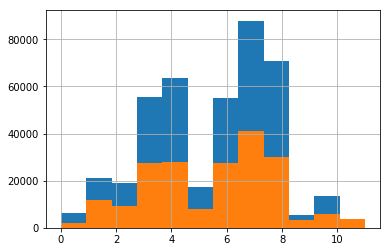

In [5]:
x_train.SECTOR.hist(bins=nb_sec)
test.SECTOR.hist(bins=nb_sec)

In [6]:
train.groupby(by='SECTOR').count()['DATE']
#test.groupby(by='STOCK').count()['DATE']

SECTOR
0      6304
1     21264
2     18967
3     55473
4     63519
5     17295
6     55123
7     87903
8     70843
9      5555
10    13295
11     3054
Name: DATE, dtype: int64

# Définition des fonctions d'arborescence

In [7]:
arbre = ['SECTOR','INDUSTRY_GROUP','INDUSTRY','SUB_INDUSTRY','STOCK'];

def niv_arbre(df, lvl_arb, chemin, nb_min_per_mod):
    
    if (lvl_arb == 4 and df.shape[0]>nb_min_per_mod):
            return([[4,df.shape[0],chemin,chemin]])
    
    elif (df.shape[0]<nb_min_per_mod):
        
        if (lvl_arb == 0):
            return([lvl_arb, df.shape[0], chemin, chemin])
        
        return([lvl_arb, df.shape[0], chemin, chemin[0:len(chemin)-1]])
   
    else :
        res = []
   
        for sub_step in (df[arbre[lvl_arb+1]].unique()):
            sub_df = df[df[arbre[lvl_arb+1]]==sub_step]
            
            if sub_df.shape[0]>nb_min_per_mod:
                res = res + niv_arbre(sub_df,lvl_arb+1, chemin+[sub_step],nb_min_per_mod)
                
            elif (lvl_arb == -1):
                res = res + [[0,sub_df.shape[0],chemin+[sub_step],chemin+[sub_step]]]
                
            else : 
                res = res + [[lvl_arb,sub_df.shape[0],chemin+[sub_step],chemin]]
       
        return(res)

def creer_niv_arbre(df, nb_min_per_mod):
    
    grp_data = niv_arbre(df, -1, [], nb_min_per_mod) 
    
    for i in range(12):
        grp_data.append([0,0,0,[i]])
        
    models = np.unique(np.asarray(grp_data)[:,3])
    
    new_model = []
    for i in range(5,-1,-1):  
        for model in models:
            div = len(model)-1
            if i == div:
                new_model.append([div,model[div]])
    models = new_model
    
    
    return(grp_data,models)

# Cross validation

In [20]:
# Paramètres :
N = 5 #nombre de folds
nb_feat = 20 #nb de jours pris en compte
nb_shifts = 5 #nombre de features supplémentaires
liste_seuils = [int(k) for k in np.linspace(30000,42000,5)]

scores = [[] for k in range(len(liste_seuils))]

for ind_seuil,seuil_arbo in enumerate(liste_seuils):

    # Séparation en N folds :
    kf = KFold(n_splits=N,shuffle=True,random_state=1)
    for fold, (ind_train, ind_test) in enumerate(kf.split(train)):

        # Nettoyage des données :
        train_cl = train.loc[ind_train]
        test_cl = train.loc[ind_test]
        for indu in range(nb_ind):
            for ret_t,vol_t in zip(ret,vol):
                med_ret_train = train[ret_t][train['INDUSTRY_GROUP']==indu].median()
                med_vol_train = train[vol_t][train['INDUSTRY_GROUP']==indu].median()
                med_ret_test = train[ret_t][train['INDUSTRY_GROUP']==indu].median()
                med_vol_test = train[vol_t][train['INDUSTRY_GROUP']==indu].median()

                train_cl[ret_t] = train_cl[ret_t].fillna(med_ret_train)
                train_cl[vol_t] = train_cl[vol_t].fillna(med_vol_train)
                test_cl[ret_t] = test_cl[ret_t].fillna(med_ret_test)
                test_cl[vol_t] = test_cl[vol_t].fillna(med_vol_test)
        seuil_ret = 1000;
        seuil_vol = 1000;
        train_cl  = train_cl [np.all([train_cl[col]<seuil_ret for col in ret],axis=0)]
        train_cl  = train_cl [np.all([train_cl[col]<seuil_vol for col in vol],axis=0)]

        # Mise à l'échelle :
        scaler = StandardScaler()
        train_cl[ret+vol] = scaler.fit_transform(train_cl[ret+vol])
        test_cl[ret+vol] = scaler.fit_transform(test_cl[ret+vol])

        # Création de l'arborescence :
        grp_data, loc_mods = creer_niv_arbre(train_cl,seuil_arbo)
        print('Nous allons creer', len(loc_mods), 'modèles afin de couvrir les', len(grp_data), 'groupes de données détectés.')

        # Sélection des features :
        features_base = ret[-nb_feat:]+vol[-nb_feat:]
        target = 'RET'

        shifts = range(1,nb_shifts+1)
        new_features = []
        statistics = ['median']
        target_feature = 'RET'
        for shift in range(1,nb_shifts+1):
            print(shift)
            for stat in statistics:
                feat = f'{target_feature}_{shift}'
                name = f'{target_feature}_{shift}_SUBDIVISION_{stat}'
                new_features.append(name)

                train_new = pd.Series()
                test_new = pd.Series()

                grille_train = pd.Series(index=train_cl.index)
                grille_test = pd.Series(index=test_cl.index)


                for n in range(len(loc_mods)):    

                    grp = loc_mods[n]
                    niv = grp[0]

                    if niv == 5:
                        gb_features = ['STOCK', 'DATE']
                    else:
                        gb_features = [arbre[niv], 'DATE']

                    train_set_sub = train_cl[train_cl[arbre[niv]]==grp[1]]
                    test_set_sub = test_cl[test_cl[arbre[niv]]==grp[1]]

                    train_set_sub = train_set_sub[grille_train.isna()]
                    test_set_sub = test_set_sub[grille_test.isna()]

                    train_index = train_set_sub.index
                    test_index = test_set_sub.index

                    grille_train[train_index] = 1
                    grille_test[test_index] = 1

                    train_new_sub = pd.Series(train_set_sub.groupby(gb_features)[feat].transform(stat),index=train_index)
                    test_new_sub = pd.Series(test_set_sub.groupby(gb_features)[feat].transform(stat),index=test_index)

                    train_new = pd.concat([train_new,train_new_sub])
                    test_new = pd.concat([test_new,test_new_sub])

                train_cl[name] = train_new
                test_cl[name] = test_new

        features = features_base + new_features

        # Entraînement des modèles
        models = []
        arbre_minuscule = ["du secteur","du groupe industriel","de l'industrie","de la sous-industrie","de l'action"]
        print(len(loc_mods), 'modèles à créer')
        for n in range(len(loc_mods)):
            loc_mod = loc_mods[n]
            niv = loc_mod[0]
            sub = loc_mod[1]

            x_train_cl = train_cl[features][train_cl[arbre[niv]]==sub]
            y_train_cl = train_cl[target][train_cl[arbre[niv]]==sub]
            print("Modèle", n,": calculé sur les données",arbre_minuscule[niv],sub,".",x_train_cl.shape[0],"données.")

            rf_params = {
            'n_estimators': 500,
            'max_depth': 2**3,
            'random_state': 0,
            'n_jobs': -1
            }

            model = RandomForestClassifier(**rf_params)
            model.fit(x_train_cl, y_train_cl)
            models.append([model,[niv,sub]])

        # Prédiction
        y_pred = pd.Series()
        y_test= pd.Series(index=test_cl.index)


        nb_ligne = 0;
        for n in range(len(models)):
            model = models[n][0]

            print("Groupe : ", n)

            div = arbre[models[n][1][0]]  
            sub = models[n][1][1] 

            x_test = test_cl[test_cl[div]==sub].loc[:,features]
            x_test = x_test[y_test.isna()]

            if (x_test.shape[0] > 0):

                index = x_test.index
                y_test[index]=1

                y_new = pd.Series(model.predict(x_test),index=index)
                y_pred = pd.concat([y_pred,y_new])

        y_pred = y_pred.sort_index()

        score = accuracy_score(test_cl[target], y_pred)
        print(f"Score fold {fold+1} : {score* 100:.2f}")
        scores[ind_seuil].append(score)

    # Résultats finaux :
    mean = np.mean(scores[ind_seuil])*100
    std = np.std(scores[ind_seuil])*100
    u = (mean + std)
    l = (mean - std)
    print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Nous allons creer 13 modèles afin de couvrir les 37 groupes de données détectés.
1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

13 modèles à créer
Modèle 0 : calculé sur les données du groupe industriel 16 . 31529 données.
Modèle 1 : calculé sur les données du secteur 0 . 5005 données.
Modèle 2 : calculé sur les données du secteur 1 . 17053 données.
Modèle 3 : calculé sur les données du secteur 2 . 15163 données.
Modèle 4 : calculé sur les données du secteur 3 . 44133 données.
Modèle 5 : calculé sur les données du secteur 4 . 50989 données.
Modèle 6 : calculé sur les données du secteur 5 . 13841 données.
Modèle 7 : calculé sur les données du secteur 6 . 44134 données.
Modèle 8 : calculé sur les données du secteur 7 . 70433 données.
Modèle 9 : calculé sur les données du secteur 8 . 56591 données.
Modèle 10 : calculé sur les données du secteur 9 . 4450 données.
Modèle 11 : calculé sur les données du secteur 10 . 10651 données.
Modèle 12 : calculé sur les données du secteur 11 . 2432 données.
Groupe :  0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  1
Groupe :  2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  9


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  10
Groupe :  11


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  12
Score fold 1 : 56.38


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Nous allons creer 13 modèles afin de couvrir les 37 groupes de données détectés.
1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

13 modèles à créer
Modèle 0 : calculé sur les données du groupe industriel 16 . 31471 données.
Modèle 1 : calculé sur les données du secteur 0 . 5064 données.
Modèle 2 : calculé sur les données du secteur 1 . 17038 données.
Modèle 3 : calculé sur les données du secteur 2 . 15238 données.
Modèle 4 : calculé sur les données du secteur 3 . 44527 données.
Modèle 5 : calculé sur les données du secteur 4 . 50657 données.
Modèle 6 : calculé sur les données du secteur 5 . 13837 données.
Modèle 7 : calculé sur les données du secteur 6 . 43986 données.
Modèle 8 : calculé sur les données du secteur 7 . 70306 données.
Modèle 9 : calculé sur les données du secteur 8 . 56629 données.
Modèle 10 : calculé sur les données du secteur 9 . 4433 données.
Modèle 11 : calculé sur les données du secteur 10 . 10715 données.
Modèle 12 : calculé sur les données du secteur 11 . 2445 données.
Groupe :  0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  1
Groupe :  2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  9


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  10
Groupe :  11


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  12
Score fold 2 : 56.53


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Nous allons creer 13 modèles afin de couvrir les 37 groupes de données détectés.
1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

13 modèles à créer
Modèle 0 : calculé sur les données du groupe industriel 16 . 31338 données.
Modèle 1 : calculé sur les données du secteur 0 . 5033 données.
Modèle 2 : calculé sur les données du secteur 1 . 17099 données.
Modèle 3 : calculé sur les données du secteur 2 . 15118 données.
Modèle 4 : calculé sur les données du secteur 3 . 44445 données.
Modèle 5 : calculé sur les données du secteur 4 . 50713 données.
Modèle 6 : calculé sur les données du secteur 5 . 13857 données.
Modèle 7 : calculé sur les données du secteur 6 . 44101 données.
Modèle 8 : calculé sur les données du secteur 7 . 70286 données.
Modèle 9 : calculé sur les données du secteur 8 . 56766 données.
Modèle 10 : calculé sur les données du secteur 9 . 4410 données.
Modèle 11 : calculé sur les données du secteur 10 . 10574 données.
Modèle 12 : calculé sur les données du secteur 11 . 2473 données.
Groupe :  0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  1
Groupe :  2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  9


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  10
Groupe :  11


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  12
Score fold 3 : 56.19


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Nous allons creer 13 modèles afin de couvrir les 37 groupes de données détectés.
1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

13 modèles à créer
Modèle 0 : calculé sur les données du groupe industriel 16 . 31347 données.
Modèle 1 : calculé sur les données du secteur 0 . 5065 données.
Modèle 2 : calculé sur les données du secteur 1 . 16893 données.
Modèle 3 : calculé sur les données du secteur 2 . 15193 données.
Modèle 4 : calculé sur les données du secteur 3 . 44399 données.
Modèle 5 : calculé sur les données du secteur 4 . 50970 données.
Modèle 6 : calculé sur les données du secteur 5 . 13819 données.
Modèle 7 : calculé sur les données du secteur 6 . 44186 données.
Modèle 8 : calculé sur les données du secteur 7 . 70113 données.
Modèle 9 : calculé sur les données du secteur 8 . 56690 données.
Modèle 10 : calculé sur les données du secteur 9 . 4498 données.
Modèle 11 : calculé sur les données du secteur 10 . 10610 données.
Modèle 12 : calculé sur les données du secteur 11 . 2439 données.
Groupe :  0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  1
Groupe :  2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  9


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  10
Groupe :  11


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  12
Score fold 4 : 56.23


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Nous allons creer 13 modèles afin de couvrir les 37 groupes de données détectés.
1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

13 modèles à créer
Modèle 0 : calculé sur les données du groupe industriel 16 . 31475 données.
Modèle 1 : calculé sur les données du secteur 0 . 5049 données.
Modèle 2 : calculé sur les données du secteur 1 . 16973 données.
Modèle 3 : calculé sur les données du secteur 2 . 15156 données.
Modèle 4 : calculé sur les données du secteur 3 . 44388 données.
Modèle 5 : calculé sur les données du secteur 4 . 50747 données.
Modèle 6 : calculé sur les données du secteur 5 . 13826 données.
Modèle 7 : calculé sur les données du secteur 6 . 44081 données.
Modèle 8 : calculé sur les données du secteur 7 . 70474 données.
Modèle 9 : calculé sur les données du secteur 8 . 56696 données.
Modèle 10 : calculé sur les données du secteur 9 . 4429 données.
Modèle 11 : calculé sur les données du secteur 10 . 10630 données.
Modèle 12 : calculé sur les données du secteur 11 . 2427 données.
Groupe :  0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  1
Groupe :  2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  9


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  10
Groupe :  11


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  12
Score fold 5 : 56.11
Accuracy: 56.29% [56.14 ; 56.44] (+- 0.15)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Nous allons creer 12 modèles afin de couvrir les 36 groupes de données détectés.
1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

12 modèles à créer
Modèle 0 : calculé sur les données du secteur 0 . 5005 données.
Modèle 1 : calculé sur les données du secteur 1 . 17053 données.
Modèle 2 : calculé sur les données du secteur 2 . 15163 données.
Modèle 3 : calculé sur les données du secteur 3 . 44133 données.
Modèle 4 : calculé sur les données du secteur 4 . 50989 données.
Modèle 5 : calculé sur les données du secteur 5 . 13841 données.
Modèle 6 : calculé sur les données du secteur 6 . 44134 données.
Modèle 7 : calculé sur les données du secteur 7 . 70433 données.
Modèle 8 : calculé sur les données du secteur 8 . 56591 données.
Modèle 9 : calculé sur les données du secteur 9 . 4450 données.
Modèle 10 : calculé sur les données du secteur 10 . 10651 données.
Modèle 11 : calculé sur les données du secteur 11 . 2432 données.
Groupe :  0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  9
Groupe :  10


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  11
Score fold 1 : 56.17


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Nous allons creer 12 modèles afin de couvrir les 36 groupes de données détectés.
1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

12 modèles à créer
Modèle 0 : calculé sur les données du secteur 0 . 5064 données.
Modèle 1 : calculé sur les données du secteur 1 . 17038 données.
Modèle 2 : calculé sur les données du secteur 2 . 15238 données.
Modèle 3 : calculé sur les données du secteur 3 . 44527 données.
Modèle 4 : calculé sur les données du secteur 4 . 50657 données.
Modèle 5 : calculé sur les données du secteur 5 . 13837 données.
Modèle 6 : calculé sur les données du secteur 6 . 43986 données.
Modèle 7 : calculé sur les données du secteur 7 . 70306 données.
Modèle 8 : calculé sur les données du secteur 8 . 56629 données.
Modèle 9 : calculé sur les données du secteur 9 . 4433 données.
Modèle 10 : calculé sur les données du secteur 10 . 10715 données.
Modèle 11 : calculé sur les données du secteur 11 . 2445 données.
Groupe :  0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  9
Groupe :  10


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  11
Score fold 2 : 56.09


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Nous allons creer 12 modèles afin de couvrir les 36 groupes de données détectés.
1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

12 modèles à créer
Modèle 0 : calculé sur les données du secteur 0 . 5033 données.
Modèle 1 : calculé sur les données du secteur 1 . 17099 données.
Modèle 2 : calculé sur les données du secteur 2 . 15118 données.
Modèle 3 : calculé sur les données du secteur 3 . 44445 données.
Modèle 4 : calculé sur les données du secteur 4 . 50713 données.
Modèle 5 : calculé sur les données du secteur 5 . 13857 données.
Modèle 6 : calculé sur les données du secteur 6 . 44101 données.
Modèle 7 : calculé sur les données du secteur 7 . 70286 données.
Modèle 8 : calculé sur les données du secteur 8 . 56766 données.
Modèle 9 : calculé sur les données du secteur 9 . 4410 données.
Modèle 10 : calculé sur les données du secteur 10 . 10574 données.
Modèle 11 : calculé sur les données du secteur 11 . 2473 données.
Groupe :  0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  9
Groupe :  10


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  11
Score fold 3 : 56.17


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Nous allons creer 12 modèles afin de couvrir les 36 groupes de données détectés.
1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

12 modèles à créer
Modèle 0 : calculé sur les données du secteur 0 . 5065 données.
Modèle 1 : calculé sur les données du secteur 1 . 16893 données.
Modèle 2 : calculé sur les données du secteur 2 . 15193 données.
Modèle 3 : calculé sur les données du secteur 3 . 44399 données.
Modèle 4 : calculé sur les données du secteur 4 . 50970 données.
Modèle 5 : calculé sur les données du secteur 5 . 13819 données.
Modèle 6 : calculé sur les données du secteur 6 . 44186 données.
Modèle 7 : calculé sur les données du secteur 7 . 70113 données.
Modèle 8 : calculé sur les données du secteur 8 . 56690 données.
Modèle 9 : calculé sur les données du secteur 9 . 4498 données.
Modèle 10 : calculé sur les données du secteur 10 . 10610 données.
Modèle 11 : calculé sur les données du secteur 11 . 2439 données.
Groupe :  0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  9


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  10


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  11
Score fold 4 : 56.07


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Nous allons creer 12 modèles afin de couvrir les 36 groupes de données détectés.
1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

12 modèles à créer
Modèle 0 : calculé sur les données du secteur 0 . 5049 données.
Modèle 1 : calculé sur les données du secteur 1 . 16973 données.
Modèle 2 : calculé sur les données du secteur 2 . 15156 données.
Modèle 3 : calculé sur les données du secteur 3 . 44388 données.
Modèle 4 : calculé sur les données du secteur 4 . 50747 données.
Modèle 5 : calculé sur les données du secteur 5 . 13826 données.
Modèle 6 : calculé sur les données du secteur 6 . 44081 données.
Modèle 7 : calculé sur les données du secteur 7 . 70474 données.
Modèle 8 : calculé sur les données du secteur 8 . 56696 données.
Modèle 9 : calculé sur les données du secteur 9 . 4429 données.
Modèle 10 : calculé sur les données du secteur 10 . 10630 données.
Modèle 11 : calculé sur les données du secteur 11 . 2427 données.
Groupe :  0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  9
Groupe :  10


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  11
Score fold 5 : 55.97
Accuracy: 56.09% [56.02 ; 56.17] (+- 0.07)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Nous allons creer 12 modèles afin de couvrir les 36 groupes de données détectés.
1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

12 modèles à créer
Modèle 0 : calculé sur les données du secteur 0 . 5005 données.
Modèle 1 : calculé sur les données du secteur 1 . 17053 données.
Modèle 2 : calculé sur les données du secteur 2 . 15163 données.
Modèle 3 : calculé sur les données du secteur 3 . 44133 données.
Modèle 4 : calculé sur les données du secteur 4 . 50989 données.
Modèle 5 : calculé sur les données du secteur 5 . 13841 données.
Modèle 6 : calculé sur les données du secteur 6 . 44134 données.
Modèle 7 : calculé sur les données du secteur 7 . 70433 données.
Modèle 8 : calculé sur les données du secteur 8 . 56591 données.
Modèle 9 : calculé sur les données du secteur 9 . 4450 données.
Modèle 10 : calculé sur les données du secteur 10 . 10651 données.
Modèle 11 : calculé sur les données du secteur 11 . 2432 données.
Groupe :  0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  9
Groupe :  10


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  11
Score fold 1 : 56.17


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Nous allons creer 12 modèles afin de couvrir les 36 groupes de données détectés.
1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

12 modèles à créer
Modèle 0 : calculé sur les données du secteur 0 . 5064 données.
Modèle 1 : calculé sur les données du secteur 1 . 17038 données.
Modèle 2 : calculé sur les données du secteur 2 . 15238 données.
Modèle 3 : calculé sur les données du secteur 3 . 44527 données.
Modèle 4 : calculé sur les données du secteur 4 . 50657 données.
Modèle 5 : calculé sur les données du secteur 5 . 13837 données.
Modèle 6 : calculé sur les données du secteur 6 . 43986 données.
Modèle 7 : calculé sur les données du secteur 7 . 70306 données.
Modèle 8 : calculé sur les données du secteur 8 . 56629 données.
Modèle 9 : calculé sur les données du secteur 9 . 4433 données.
Modèle 10 : calculé sur les données du secteur 10 . 10715 données.
Modèle 11 : calculé sur les données du secteur 11 . 2445 données.
Groupe :  0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  9
Groupe :  10


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  11
Score fold 2 : 56.09


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Nous allons creer 12 modèles afin de couvrir les 36 groupes de données détectés.
1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

12 modèles à créer
Modèle 0 : calculé sur les données du secteur 0 . 5033 données.
Modèle 1 : calculé sur les données du secteur 1 . 17099 données.
Modèle 2 : calculé sur les données du secteur 2 . 15118 données.
Modèle 3 : calculé sur les données du secteur 3 . 44445 données.
Modèle 4 : calculé sur les données du secteur 4 . 50713 données.
Modèle 5 : calculé sur les données du secteur 5 . 13857 données.
Modèle 6 : calculé sur les données du secteur 6 . 44101 données.
Modèle 7 : calculé sur les données du secteur 7 . 70286 données.
Modèle 8 : calculé sur les données du secteur 8 . 56766 données.
Modèle 9 : calculé sur les données du secteur 9 . 4410 données.
Modèle 10 : calculé sur les données du secteur 10 . 10574 données.
Modèle 11 : calculé sur les données du secteur 11 . 2473 données.
Groupe :  0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  9
Groupe :  10


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  11
Score fold 3 : 56.17


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Nous allons creer 12 modèles afin de couvrir les 36 groupes de données détectés.
1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

12 modèles à créer
Modèle 0 : calculé sur les données du secteur 0 . 5065 données.
Modèle 1 : calculé sur les données du secteur 1 . 16893 données.
Modèle 2 : calculé sur les données du secteur 2 . 15193 données.
Modèle 3 : calculé sur les données du secteur 3 . 44399 données.
Modèle 4 : calculé sur les données du secteur 4 . 50970 données.
Modèle 5 : calculé sur les données du secteur 5 . 13819 données.
Modèle 6 : calculé sur les données du secteur 6 . 44186 données.
Modèle 7 : calculé sur les données du secteur 7 . 70113 données.
Modèle 8 : calculé sur les données du secteur 8 . 56690 données.
Modèle 9 : calculé sur les données du secteur 9 . 4498 données.
Modèle 10 : calculé sur les données du secteur 10 . 10610 données.
Modèle 11 : calculé sur les données du secteur 11 . 2439 données.
Groupe :  0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  9
Groupe :  10


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  11
Score fold 4 : 56.07


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Nous allons creer 12 modèles afin de couvrir les 36 groupes de données détectés.
1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

12 modèles à créer
Modèle 0 : calculé sur les données du secteur 0 . 5049 données.
Modèle 1 : calculé sur les données du secteur 1 . 16973 données.
Modèle 2 : calculé sur les données du secteur 2 . 15156 données.
Modèle 3 : calculé sur les données du secteur 3 . 44388 données.
Modèle 4 : calculé sur les données du secteur 4 . 50747 données.
Modèle 5 : calculé sur les données du secteur 5 . 13826 données.
Modèle 6 : calculé sur les données du secteur 6 . 44081 données.
Modèle 7 : calculé sur les données du secteur 7 . 70474 données.
Modèle 8 : calculé sur les données du secteur 8 . 56696 données.
Modèle 9 : calculé sur les données du secteur 9 . 4429 données.
Modèle 10 : calculé sur les données du secteur 10 . 10630 données.
Modèle 11 : calculé sur les données du secteur 11 . 2427 données.
Groupe :  0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  6


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  7


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  8


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  9
Groupe :  10


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Groupe :  11
Score fold 5 : 55.97
Accuracy: 56.09% [56.02 ; 56.17] (+- 0.07)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Nous allons creer 12 modèles afin de couvrir les 36 groupes de données détectés.
1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

4


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match Da

5


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match Da

12 modèles à créer
Modèle 0 : calculé sur les données du secteur 0 . 5005 données.
Modèle 1 : calculé sur les données du secteur 1 . 17053 données.
Modèle 2 : calculé sur les données du secteur 2 . 15163 données.
Modèle 3 : calculé sur les données du secteur 3 . 44133 données.
Modèle 4 : calculé sur les données du secteur 4 . 50989 données.
Modèle 5 : calculé sur les données du secteur 5 . 13841 données.
Modèle 6 : calculé sur les données du secteur 6 . 44134 données.


KeyboardInterrupt: 

In [9]:
scores

[[0.560541812491788,
  0.5588695517146646,
  0.5552861357636857,
  0.5578423058087173,
  0.5549039047289146],
 [0.5598967976206118,
  0.559801239861919,
  0.5571495120581946,
  0.5582484262831615,
  0.5571972909375411],
 [0.561222661522474,
  0.5612465509621472,
  0.5578303610888806,
  0.5582006474038151,
  0.5587262150766253],
 [0.5613540534406766,
  0.5613062745613302,
  0.5568389493424432,
  0.5570897884590117,
  0.5585828784385862],
 [0.5609479329662322,
  0.5606254255306442,
  0.5561461555919206,
  0.556014763673718,
  0.5584514865203837],
 [0.5586903809171155,
  0.5609718224059055,
  0.5550114072074439,
  0.5565403313465282,
  0.5602431944958731],
 [0.5591562249907428,
  0.5613659981605131,
  0.5566836679845675,
  0.5573047934160704,
  0.561162937923291],
 [0.5598848529007752,
  0.562345465187114,
  0.5580214766062662,
  0.5577945269293709,
  0.5640057812444009],
 [0.5601118025776706,
  0.5616885055961013,
  0.5583917629212006,
  0.5585350995592399,
  0.5641849520419498],
 [0.560

In [22]:
x_trace = np.append(x_trace,np.linspace(30000,36000,3))
y_trace = np.append(y_trace,[np.mean(scores[k]) for k in range(3)])
std_trace = np.append(std_trace,[np.std(scores[k]) for k in range(3)])

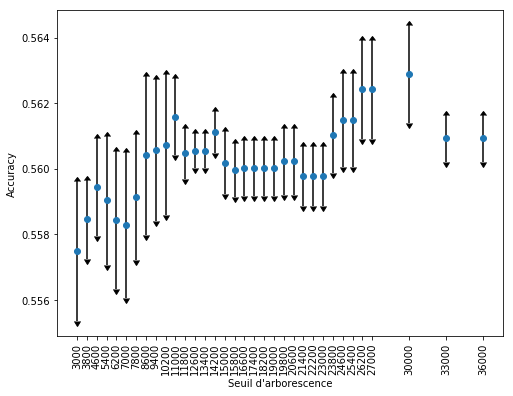

In [28]:
plt.figure(figsize=[8,6])
plt.errorbar(x_trace,y_trace,std_trace,uplims=True,lolims=True,fmt='o',ecolor='k')
plt.xticks(x_trace)
plt.xticks(rotation=90)
plt.xlabel("Seuil d'arborescence")
plt.ylabel("Accuracy")
plt.show()

In [18]:
# results_df = pd.DataFrame(scores)
# results_df['Seuil'] = x_trace
# results_df['Moy'] = [np.mean(scores[k]) for k in range(31)]
# results_df

,0,1,2,3,4,Seuil,Moy
0,0.560542,0.558870,0.555286,0.557842,0.554904,3000.0,0.557489
1,0.559897,0.559801,0.557150,0.558248,0.557197,3800.0,0.558459
2,0.561223,0.561247,0.557830,0.558201,0.558726,4600.0,0.559445
3,0.561354,0.561306,0.556839,0.557090,0.558583,5400.0,0.559034
4,0.560948,0.560625,0.556146,0.556015,0.558451,6200.0,0.558437
5,0.558690,0.560972,0.555011,0.556540,0.560243,7000.0,0.558291
6,0.559156,0.561366,0.556684,0.557305,0.561163,7800.0,0.559135
7,0.559885,0.562345,0.558021,0.557795,0.564006,8600.0,0.560410
8,0.560112,0.561689,0.558392,0.558535,0.564185,9400.0,0.560582
9,0.560852,0.561689,0.558392,0.558535,0.564185,10200.0,0.560731


In [19]:
# results_df.to_csv("Recherche_seuil1114F2")

In [26]:
train.groupby(by='INDUSTRY_GROUP').count()['DATE']*.8

INDUSTRY_GROUP
0      5043.2
1     17011.2
2     15173.6
3     27670.4
4     10400.8
5      6307.2
6      3296.8
7     11037.6
8     11597.6
9      8887.2
10    15996.0
11     3117.6
12     7666.4
13     3052.0
14    20999.2
15    23099.2
16    31432.0
17    12238.4
18    11721.6
19    14930.4
20    26120.0
21    19343.2
22    11211.2
23     4444.0
25    10636.0
26     2443.2
Name: DATE, dtype: float64